In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [4]:
%%R

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged

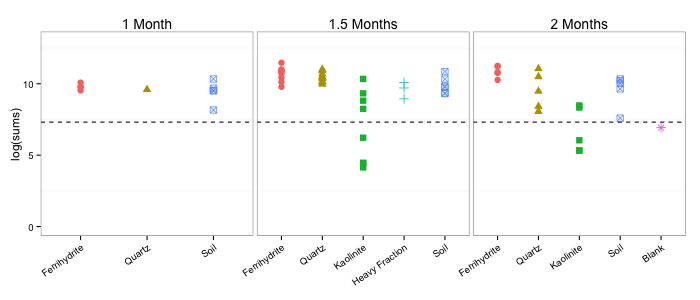

In [6]:
%%R -w 700 -h 300

sums = (sample_sums(physeq))
mdf = data.frame(sums)
mdf[,2] = row.names(mdf)
names = colnames(mdf)
mdf[,3] = substr(mdf[,2],1,1)
mdf[,4] = substr(mdf[,2],3,4)
colnames(mdf) = c(names[1],"Samples","Trtmt", "Month")
mdf$MonthName = ifelse(mdf$Month=='2_',"1 Month",(ifelse(mdf$Month=="2.", "1.5 Months","2 Months")))
mdf$Trtmt[mdf$Trtmt=="B"]="Blank"
mdf$Trtmt[mdf$Trtmt=="F"]="Ferrihydrite"
mdf$Trtmt[mdf$Trtmt=="Q"]="Quartz"
mdf$Trtmt[mdf$Trtmt=="H"]="Heavy Fraction"
mdf$Trtmt[mdf$Trtmt=="S"]="Soil"
mdf$Trtmt[mdf$Trtmt=="K"]="Kaolinite"
mdf$Trtmt = ordered(mdf$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil","Blank"))

p = ggplot(mdf, aes(x=Trtmt, y=log(sums), colour = Trtmt, shape = Trtmt))
p = p + facet_grid(~MonthName, scales="free_x")
p = p + geom_point(size = 3)
p = p + geom_hline(yintercept=log(1500),linetype='dashed',weight=2)
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=35, hjust=1),panel.grid.major= element_blank(), axis.title.x = element_blank(),strip.background = element_blank(),strip.text = element_text(size=14))
p = p + ylim(0,13)
p = p + guides(shape=FALSE,colour=FALSE)
ggsave(filename="Cutoff16S.jpg", p, width=7, height=3)
p